Author: Tony Yum

## Example of training AI to trade

Run the below the first time an instance is created to install necessary libs

In [1]:
!python3 -m pip install --upgrade pip
!pip install kydb matplotlib feather-format s3fs boto3 --upgrade

  Using cached pip-20.2.4-py2.py3-none-any.whl (1.5 MB)
  Attempting uninstall: pip
    Found existing installation: pip 20.0.2
    Uninstalling pip-20.0.2:
      Successfully uninstalled pip-20.0.2
  Using cached kydb-0.5.0-py3-none-any.whl (20 kB)
  Using cached matplotlib-3.3.2-cp36-cp36m-manylinux1_x86_64.whl (11.6 MB)
Processing ./.cache/pip/wheels/9d/90/64/88411837e80bb520d15ae395f39359a5413e7a00ae63397e10/feather_format-0.4.1-py3-none-any.whl
  Using cached s3fs-0.5.1-py3-none-any.whl (21 kB)
  Using cached boto3-1.16.6-py2.py3-none-any.whl (129 kB)
  Using cached redis-3.5.3-py2.py3-none-any.whl (72 kB)
  Using cached certifi-2020.6.20-py2.py3-none-any.whl (156 kB)
  Using cached cycler-0.10.0-py2.py3-none-any.whl (6.5 kB)
  Using cached kiwisolver-1.3.0-cp36-cp36m-manylinux2010_x86_64.whl (1.6 MB)
  Using cached pyarrow-2.0.0-cp36-cp36m-manylinux2014_x86_64.whl (17.7 MB)
  Using cached fsspec-0.8.4-py3-none-any.whl (91 kB)
  Using cached aiobotocore-1.1.2-py3-none-any.whl (45 

## Imports

Add epython-showcase to PYTHONPATH

In [1]:
import os
os.sys.path.append('epython-showcase')

Import the libs

In [2]:
import kydb
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import load_model
import math
from datetime import date
from multiprocessing import Pool, cpu_count
from ml.train_sequence import TrainSequence
%matplotlib inline

## Download the training data

In [3]:
start_date = date(2017, 6, 1)
end_date = date(2020, 6, 1)
db = kydb.connect('dynamodb://epython/timeseries')
ts = db['/symbols/ml/training_data/FX_BTC_JPY']
pos_df = ts.curve(start_date, end_date)

## Setup the model and train

### Test on 3 days data

In [4]:
start_time = 3*30*24*60

seq = TrainSequence(pos_df[start_time-60*24:start_time+60*24*2].reset_index()[['mid', 'position']].copy())
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(512, input_shape=(seq.lookback_period,), activation=tf.nn.relu),    
  tf.keras.layers.Dense(512, activation=tf.nn.relu),  
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])              

model.fit_generator(generator=seq, epochs=5, workers=cpu_count(), use_multiprocessing=True)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Epoch 1/5
90/90 [==============================] - 3s 37ms/step - loss: 0.4295 - acc: 0.7903
Epoch 2/5
90/90 [==============================] - 3s 35ms/step - loss: 0.1045 - acc: 0.9601
Epoch 3/5
90/90 [==============================] - 3s 34ms/step - loss: 0.0727 - acc: 0.9740
Epoch 4/5
90/90 [==============================] - 3s 35ms/step - loss: 0.0828 - acc: 0.9688
Epoch 5/5
90/90 [==============================] - 3s 35ms/step - loss: 0.0519 - acc: 0.9774


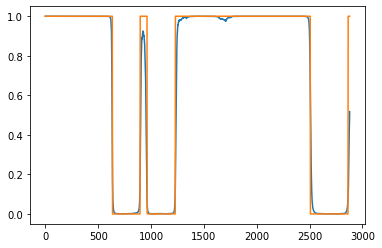

In [5]:
def get_batch(args):
    idx, seq = args
    return seq[idx]

def plot_actual_vs_predict(model, t1, t2):
    seq = TrainSequence(pos_df[t1:t2].reset_index()[['mid', 'position']].copy(), enable_shuffle=False)
    p = Pool(cpu_count())
    batches = p.map(get_batch, enumerate([seq] * len(seq)))

    xs = np.concatenate([batches[i][0] for i in range(len(seq))])
    ys = np.concatenate([batches[i][1] for i in range(len(seq))])
    y_pred = model.predict(xs)
    plt.plot(y_pred[:, 1])
    plt.plot(ys)

plot_actual_vs_predict(model, start_time-60*24, start_time+60*24*2)

### Test on 10 days

In [6]:
start_time = 3*30*24*60
days_to_train = 10

seq = TrainSequence(pos_df[start_time-60*24:start_time+60*24*days_to_train].reset_index()[['mid', 'position']].copy())
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(512, input_shape=(seq.lookback_period,), activation=tf.nn.relu),    
  tf.keras.layers.Dense(512, activation=tf.nn.relu),  
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])              

model.fit_generator(generator=seq, epochs=5, workers=cpu_count(), use_multiprocessing=True)

Epoch 1/5
450/450 [==============================] - 18s 40ms/step - loss: 0.6019 - acc: 0.6431
Epoch 2/5
450/450 [==============================] - 18s 39ms/step - loss: 0.3573 - acc: 0.8305
Epoch 3/5
450/450 [==============================] - 18s 40ms/step - loss: 0.1949 - acc: 0.9240
Epoch 4/5
450/450 [==============================] - 18s 39ms/step - loss: 0.1357 - acc: 0.9495
Epoch 5/5
450/450 [==============================] - 18s 39ms/step - loss: 0.1118 - acc: 0.9592


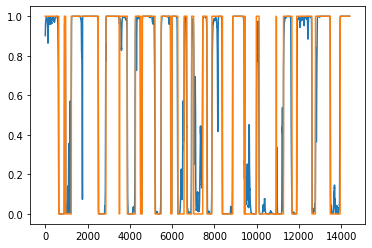

In [7]:
plot_actual_vs_predict(model, start_time-60*24, start_time+60*24*days_to_train)

### Test on 20 days

In [8]:
start_time = 3*30*24*60
days_to_train = 20

train_data = pos_df[start_time-60*24:start_time+60*24*days_to_train].reset_index()[['mid', 'position']].copy()
seq = TrainSequence(train_data, batch_size=60*6)
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(512, input_shape=(seq.lookback_period,), activation=tf.nn.relu),    
  tf.keras.layers.Dense(512, activation=tf.nn.relu),  
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])              

model.fit_generator(generator=seq, epochs=10, workers=cpu_count(), use_multiprocessing=True)

Epoch 1/10
80/80 [==============================] - 27s 343ms/step - loss: 0.7494 - acc: 0.5805
Epoch 2/10
80/80 [==============================] - 27s 342ms/step - loss: 0.6132 - acc: 0.6575
Epoch 3/10
80/80 [==============================] - 27s 341ms/step - loss: 0.5635 - acc: 0.7087
Epoch 4/10
80/80 [==============================] - 27s 341ms/step - loss: 0.5226 - acc: 0.7357
Epoch 5/10
80/80 [==============================] - 27s 341ms/step - loss: 0.4726 - acc: 0.7717
Epoch 6/10
80/80 [==============================] - 27s 341ms/step - loss: 0.3825 - acc: 0.8308
Epoch 7/10
80/80 [==============================] - 27s 342ms/step - loss: 0.3152 - acc: 0.8662
Epoch 8/10
80/80 [==============================] - 27s 341ms/step - loss: 0.2254 - acc: 0.9170
Epoch 9/10
80/80 [==============================] - 27s 342ms/step - loss: 0.1893 - acc: 0.9297
Epoch 10/10
80/80 [==============================] - 28s 345ms/step - loss: 0.1435 - acc: 0.9492


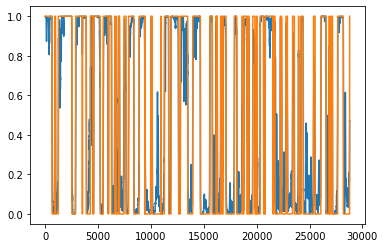

In [9]:
plot_actual_vs_predict(model, start_time-60*24, start_time+60*24*days_to_train)

### The full run

In [10]:
train_data = pos_df[-60*24*365:].reset_index()[['mid', 'position']].copy()
seq = TrainSequence(train_data, batch_size=60*24*5)
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(1024, input_shape=(seq.lookback_period,), activation=tf.nn.relu),    
  tf.keras.layers.Dense(1024, activation=tf.nn.relu),  
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(2, activation=tf.nn.softmax)
])
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])              

model.fit_generator(generator=seq, epochs=10, workers=cpu_count(), use_multiprocessing=True)

Epoch 1/10
72/72 [==============================] - 519s 7s/step - loss: 0.8653 - acc: 0.5548
Epoch 2/10
72/72 [==============================] - 520s 7s/step - loss: 0.6456 - acc: 0.6383
Epoch 3/10
72/72 [==============================] - 521s 7s/step - loss: 0.6343 - acc: 0.6482
Epoch 4/10
72/72 [==============================] - 521s 7s/step - loss: 0.6211 - acc: 0.6614
Epoch 5/10
72/72 [==============================] - 521s 7s/step - loss: 0.6098 - acc: 0.6715
Epoch 6/10
72/72 [==============================] - 522s 7s/step - loss: 0.5971 - acc: 0.6835
Epoch 7/10
72/72 [==============================] - 522s 7s/step - loss: 0.5915 - acc: 0.6868
Epoch 8/10
72/72 [==============================] - 522s 7s/step - loss: 0.5759 - acc: 0.7010
Epoch 9/10
72/72 [==============================] - 523s 7s/step - loss: 0.5659 - acc: 0.7082
Epoch 10/10
72/72 [==============================] - 523s 7s/step - loss: 0.5504 - acc: 0.7205


## Save the trained model

In [11]:
model_file = 'fx_btc_jpy_model.h5'
model.save(model_file)

In [14]:
!ls -lh fx_btc_jpy_model.h5

-rw-r--r-- 1 root root 29M Oct 28 14:36 fx_btc_jpy_model.h5


In [16]:
db = kydb.connect('s3://epython')

In [20]:
with open(model_file, 'rb') as f:
    data = f.read()

db['/ml/models/' + model_file] = data